## Custom feature map for SVM Classifier in Aqua

The key part of quantum SVM, the kernel that really distinguish it from other kernels available for SVM classicaly (such as Gaussian or Polynomial Kernels), is the quantum feature map used to map data on a high dimensional, hard to classicaly simulate, Hilbert space. For both normal Quantum Kernel SVM and Variational Classifier, the quantum feature map used is the part of the algorithm that will have the biggest impact, as it's the part of the circuit which encodes the data.

For further information please see: https://arxiv.org/pdf/1804.11326.pdf

So, in Aqua, there is a lot of options available to customize the way the feature map is built. There is four main parameters which we can try to fine tune and use normal model selection methods on: the depth, the map function, the gate set and the order of expansion.

#### The feature map in details

To understand what influence we can have on the feature map, we must firstly present it in more details.



The goal of the feature map is to put the computer in a state $|\Phi(x)><\Phi(x)|$, a vector in the Hilbert space of  density matrix, and then, the SVM will find a hyperplane separating each vector $|\Phi(x_i)><\Phi(x_i)|$ depending on their label, supported by a reduced amount of vectors (the so-called support vectors).  The great thing with this feature map is not only the great dimension it puts data in (classical Gaussian Kernel is of infinite dimension so it's not unique to quantum), but also the way they are mapped. 

We want a complex feature map (to let data be easily separable after their mapping), but also short enough to be implementable on a real computer. The authors of [this](https://arxiv.org/pdf/1804.11326.pdf) paper proposed a family of feature maps which is supposed to be both complex and short.

$$ |\Phi(x)>=\prod_d U_{\Phi(x)}H^n,\ U_{\Phi(x)}=\exp(i\sum_{S\subseteq[1,n]}\phi_S(x)\prod_{k\in S} P_k) $$

We note $d$ the number of repeated circuit (the paper uses $d=2$ for their implementation), $\phi(x)$ the map function that will create non-linearity in the data, and $P_k$ the Pauli gates used ($P_k$ means the gate $P$ is applied on the qubit $k$). These three parameters are mutable for both classification algorithms (Variational and SVM Classifier) in Aqua. The depth $d$ is highly recommended to stay $d=2$, because it is a good compromise between complexity (it is conjectured to be classicaly hard to simulate with the parameters of the paper), and length (decoherence is not an issue with only $d=2$ because it make a circuit only 10 gates long for this part, with the default settings).
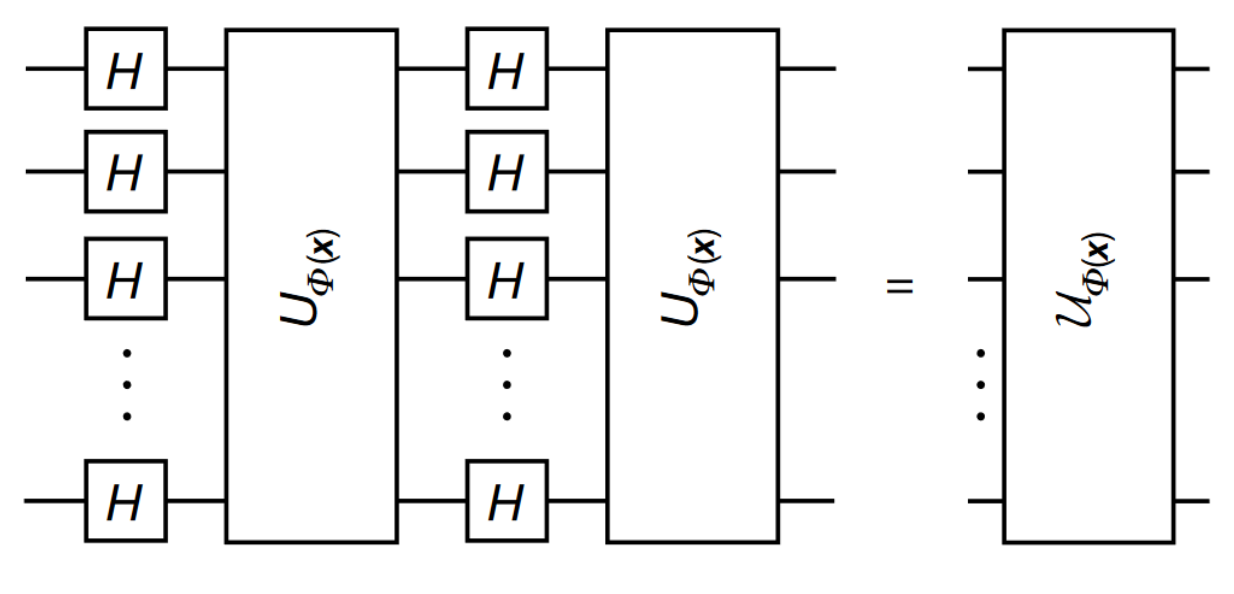

The size of $S$ can be controled too, and in Aqua it is kept at $|S|\leq 2$ by default, but can be increased. The greater the upper bound the more interactions will be taken in count. We call $r$-th order expansion the feature map of this family when $|S|\leq r$. So, by default, second order expansion is used, just like in the paper. This gives $n$ singeltons $S=\{i\}$, and, depending on the connectivity of the computer, up to $\frac{n(n-1)}{2}$ couples to encode non-linear interactions. In reality, the connectivity in a quantum computer is never complete, but it will be largely enough to encode all the interactions we want.

Then, we have the set of Pauli gates we want to use. In the article, only $Z$ gates are used, because it's simpler but other gates will give similar results.

#### Programming the feature map

We will now see how to modify these four parameters (depth, data map, gate set and expansion order) in Aqua. There is two default settings, easily configurable, which allow modifications of the depth and data map, but not the gate set. See code below to see how to use these.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, BasicAer
from qiskit_aqua.input import SVMInput
from qiskit_aqua import run_algorithm, QuantumInstance
from qiskit_aqua.algorithms import QSVMVariational
from qiskit_aqua.components.optimizers import SPSA
from qiskit_aqua.components.feature_maps import SecondOrderExpansion, FirstOrderExpansion, PauliExpansion
from qiskit_aqua.components.variational_forms import RYRZ
from sklearn import datasets
import random as r

In [2]:
#We use random data from the famous iris set.
#We don't want all the data so we take 40 samples, 20 for learning and 20 for testing
def data(feature_dim):
    iris = datasets.load_iris()
    X = iris.data[:, :feature_dim]
    label = iris.target
    m = len(X)
    random_ind = [i for i in range(m)]
    r.shuffle(random_ind)
    training_ind = random_ind[:20]
    test_ind = random_ind[20:40]
    training_input = {'-1': [X[i] for i in training_ind if label[i]<1],
                      '1': [X[i] for i in training_ind if label[i]>=1]}
    test_input = {'-1': [X[i] for i in test_ind if label[i]<1],
                  '1': [X[i] for i in test_ind if label[i]>=1]}
    return training_input, test_input

In [3]:
feature_dim = 2
X, Y = data(feature_dim)

With the data, we will use the Variational Classifier to test the feature map with the same parameters as the article. So, it's a second order expansion, of depth 2, using only $Z$ gates, and with the default data map, a full connectivity (qubit 0 is linked to qubit 1).

In [4]:
shots = 1024
random_seed = 10598

# We use the simulator
backend = BasicAer.get_backend('qasm_simulator')
# This is the SPSA optimizer used in the article
optimizer = SPSA(max_trials=100, c0=4.0, skip_calibration=True)
optimizer.set_options(save_steps=1)
# This is the form of the Variational circuit that will be trained.
# It is put in the circuit after the feature map part
var_form = RYRZ(num_qubits=feature_dim, depth=3)
quantum_instance = QuantumInstance(backend, shots=shots, seed=random_seed, seed_mapper=random_seed)

In [5]:
# We generate the feature map
feature_map = SecondOrderExpansion(num_qubits=feature_dim, depth=2)
# And run the Variational Classifier, and test it
svm = QSVMVariational(optimizer, feature_map, var_form, X, Y)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.85


Here we have used the `SecondOrderExpansion` feature map, so $|S|\leq2$. It takes the number of qubits used (same dimension as the data), the depth (number of repetition of $U_{\Phi(x)}H^n$ in the circuit), an entangler map to encode the connectivity of the computer (default is `entangler_map=None`, meaning we will use a pre-computed connectivity graph according to the next parameter), a string parameter called `entanglement`, either `'full'` or `'linear'` to generate connectivity if it isn't provided in `entangler_map` (default value is `'full'`, meaning it will consider the connectivity graph to be complete and consider all $\frac{n(n-1)}{2}$ interactions) and the data map $\phi_S(x)$ which will make non-linear connections in data (default value is  `data_map_func=self_product`, where `self_product` represents $\phi_S:x\mapsto \{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$).
    
So, even with these two feature maps one can have a lot of possibilities. We can make the feature map deeper or shorter (too deep won't have good results on real quantum computers, too short is useless because normal computer can simulate the same Kernel), we can encode the connectivity of the computer we use, and we can choose the function used to encode the data in the circuit. 

The `FirstOrderExpansion` feature map forces $|S|=1$, so there is no interaction between features of the data encoded in the circuit, and no entanglement (the $\exp(i \phi_{\{0,1\}}(x)Z_0 Z_1)$ gate used in the paper, corresponding to the second order of expansion). So, naturally it will be weaker, but shorter, which is good for a real quantum device.

In [6]:
feature_map = FirstOrderExpansion(num_qubits=feature_dim, depth=2)
svm = QSVMVariational(optimizer, feature_map, var_form, X, Y)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.95


We see here it gives better results, because the dataset is simple to separate, so a simpler model will have less issues (less overfitting for example). So this is important not to consider "the greater the order of expansion, the better", but to do actual model selection just like any other machine learning algorithm. 

As said before, we can also change the data map (the function $\phi_S$), just by defining a new map, and provide a custom entangler map by describing, in a dictionary, the graph of connections between qubits.

In [7]:
def custom_map(x):
    """A random, probably stupid custom map"""
    if len(x) == 1:
        return x[0] 
    coeff = 1
    for xi in x:
        coeff *= 0.5*(2*np.pi-xi)
    return coeff

# The entangler map is a dictionary,
# keys are source qubit index (int),
# values are array of target qubit index(es) (int)

entangler = {0:[1]} # qubit 0 linked to qubit 1 (double entanglement are not used, so no 1:[0])

In [8]:
# Here we use all available parameters for the feature map
# (entanglement='full' won't be used because we provide entangler_map)

feature_map = SecondOrderExpansion(num_qubits=feature_dim,
                                   depth=2,
                                   data_map_func=custom_map,
                                   entangler_map = entangler)
svm = QSVMVariational(optimizer, feature_map, var_form, X, Y)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  1.0


#### The PauliExpansion class for total control

For some applications, we could want to change the set of Pauli gates used, to have more flexibility, instead of using $Z$ gates only. To do that, we can use the `PauliExpansion` feature map. It has the same parameters as the other two (`depth`, `entangler_map`, `data_map_function`), but also have a `paulis` parameter to change the set.

This parameter is a `list` of `string`, each representing the Pauli gate to use (more details in the code below). The default value for this parameter is `['Z', 'ZZ']`, which makes it behave exactly like `SecondOrderExpansion`.

In [9]:
feature_map = PauliExpansion(num_qubits=feature_dim, depth=2)
svm = QSVMVariational(optimizer, feature_map, var_form, X, Y)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.75


And here we test a total change of basis for the feature map, all gates used will be $Y$.

In [10]:
feature_map = PauliExpansion(num_qubits=feature_dim, depth=2, paulis = ['Y','YY'])
svm = QSVMVariational(optimizer, feature_map, var_form, X, Y)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.4


The way it will generate the map is for each `string` in `paulis`, if it's a single character (for example `'Z'`), it will add the corresponding gate (keeping the same order), for each qubit, and if it is like `'ZZ'`, it will entangle the two qubits for each pair available.

For example, with the parameter `paulis = ['Z', 'Y', 'ZZ']`, the circuit will look like this (this is the first depth, it's actually repeated $d$ times):
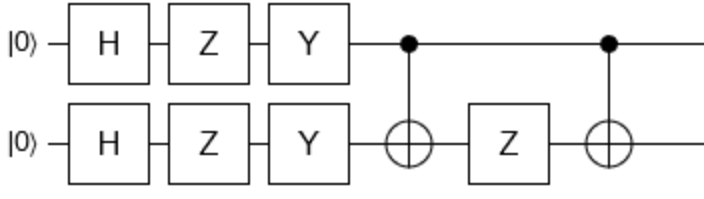

It begins with $H^n$ as always. The Z and Y gates here are rotations parametrised by the result of $\phi_S(x)$ (they are not $Y$ and $Z$ gates, but variants: Y = $e^{i\phi_{\{i\}}(x)Y_i}$ and Z = $e^{i\phi_{\{i\}}(x)Z_i}$, where $Y_i$ and $Z_i$ are the $Y$ and $Z$ gates applied on the qubit $i$). For the first columns of rotations (represented here by the first Z column and Y column), they will use the same values, respectively for each qubit $i$, $\phi_{\{i\}}(x)=x_i$, and then the entangled $ZZ$ gate uses $\phi_{\{0,1\}}(x)$ (the Z gate between the two controlled $X$).

To compare, `paulis = ['Z', 'ZZ']` is the same circuit, just without the Y gates. And `paulis = ['Z', 'YY']` will have the same start (column of $H$ and of Z, then will do the same entangled $ZZ$, but with a basis change (to put it in $Y$ basis).

The thing to note is that it allows third order or more expansions, using for example, for third order, `paulis = ['Z', 'ZZ', 'ZZZ']`. If the data has enough features and the computer has enough qubits, it will generate the feature map according to the previously mentioned rule, with $|S|\leq 3$.

So, with this `PauliExpansion` class, any member of the feature map family $\prod_d U_{\Phi(x)}H^n,\ U_{\Phi(x)}=\exp(i\sum_{S\subseteq[1,n]}\phi_S(x)\prod_{k\in S} P_k) $ can be generated, using the depth $d$, the non-linear map function $\phi_S(x)$, the expansion order $r,\ |S|\leq r$ and gate set $P_i, i\leq n$ we want.

For example, we want to classify three-dimensional data, using a third order expansion, a custom data map, a depth of 2, and a $Y$ gate for non-interactive encoding of the data, in addition to the $Z$ gates.

In [11]:
feature_dim = 3
X, Y = data(feature_dim)

In [12]:
# The depth here has nothing to do with the depth of the feature map.
# It's (more or less) the number of time the variational circuit will be repeated 
var_form = RYRZ(num_qubits=feature_dim, depth=3)

In [13]:
def custom_map(x):
    """An other random, probably stupid custom map"""
    if len(x) == 1:
        return x[0] 
    coeff = 1
    for xi in x:
        coeff *= 0.8*(2*np.pi-xi)
    return coeff

In [14]:
feature_map = PauliExpansion(num_qubits=feature_dim,
                             depth=2,
                             paulis = ['Y', 'Z', 'ZZ', 'ZZZ'],
                             data_map_func = custom_map)
svm = QSVMVariational(optimizer, feature_map, var_form, X, Y)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.85


Because the connectivity is `'full'` by default, it will add a (parametrised by $\phi_{\{i\}}(x)$) Y gate on each qubit, then a (parametrised by $\phi_{\{i\}}(x)$) Z gate, then three $ZZ$ gates (one for each pair $(0,1),\ (1,2),\ (0,2)$), and a final $ZZZ$ gate $e^{i\phi_{\{0,1,2 \}}(x)Z_0Z_1Z_2} $. It can have really poor results on this set again because it's like cracking a nut open with a bulldozer, it works too well. But with harder to classify data it could be beneficial.

#### Conclusion

We can generate all members of the feature map family presented in the article in Aqua, using the `PauliExpansion` class. But it should always be accompanied by a good model selection method to avoid all the issues we can get by using too complex models.